In [ ]:
###Load packages###
import pandas as pd
import os
import ast
from scipy import stats
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
import numpy as np

###Load cleaned dataset###

#Set file paths
topdir = '/Users/sm6511/Desktop/Prediction-Accomodation-Exp'
study = 'PrePilot4.0'
cleandir = os.path.join(topdir, f'data/{study}/Cleaned')

#Read in cleaned data (from cleaning scripts)
accomodate_path = os.path.join(cleandir, f'{study}Accomodate.csv')
predict_path   = os.path.join(cleandir, f'{study}Predict.csv')

df_accomodate = pd.read_csv(accomodate_path)
df_predict   = pd.read_csv(predict_path)

df_accomodate['task'] = 'accomodate'
df_predict['task']   = 'predict'


print("Accomodate columns:", df_accomodate.columns.tolist())
print("Predict columns:", df_predict.columns.tolist())


Accomodate columns: ['participant', 'free_texts', 'feedback', 'food_amount', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categories', 'conditionOrder', 'training_image_order', 'attention_check', 'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim', 'color_high', 'color_low', 'shape_high', 'shape_low', 'tail_high', 'tail_low', 'shape_discrete_slider.response', 'shape_direction_slider.response', 'shape_continuous_slider.response', 'color_discrete_slider.response', 'color_direction_slider.response', 'color_continuous_slider.response', 'tail_discrete_slider.response', 'tail_direction_slider.response', 'tail_continuous_slider.response', 'task']
Predict columns: ['participant', 'training_responses', 'food_amount', 'error', 'feedback', 'trial_stop_time', 'testing_image_order', 'testing_responses', 'training_categories', 'training_tail', 'training_shape', 'training_color', 'testing_categorie

Data Processing

In [36]:
#Converting string representations of lists back to lists

def parse_list_column(x):
    """take column entries that are strings representing lists and convert them to actual lists"""
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x.startswith('[') and x.endswith(']'):
            return ast.literal_eval(x)
        else:
            return [x]
    return []
for col in ['training_tail', 'training_shape', 'training_color', 'training_image_order', 'training_categories', 'testing_categories']:
    df_accomodate[col] = df_accomodate[col].apply(parse_list_column)
    df_predict[col]   = df_predict[col].apply(parse_list_column)

df_accomodate['testing_responses'] = df_accomodate['testing_responses'].apply(ast.literal_eval)
df_accomodate['food_amount'] = df_accomodate['food_amount'].apply(ast.literal_eval)
df_accomodate['testing_image_order'] = df_accomodate['testing_image_order'].apply(ast.literal_eval)
df_predict['testing_responses'] = df_predict['testing_responses'].apply(ast.literal_eval)
df_predict['food_amount'] = df_predict['food_amount'].apply(ast.literal_eval)
df_predict['testing_image_order'] = df_predict['testing_image_order'].apply(ast.literal_eval)


In [37]:
#Combine the dataframes and create an arbitrary column for participant numbering (the yoked orders are already stored in 'conditionOrder')
df_combined = pd.concat([df_accomodate, df_predict], ignore_index=True)
df_combined['participant'] = range(1, len(df_combined) + 1)


Sanity Checks

In [38]:
#Look at food amount in trainingby participant/category in accomodate task
df = df_accomodate[['participant', 'training_categories', 'food_amount']]
df_long = (
    df
    .explode(['training_categories', 'food_amount'])
    .rename(columns={'training_categories': 'category'})
)
avg_food = (
    df_long
    .groupby(['category'], as_index=False)
    ['food_amount']
    .mean()
)
print(avg_food)

  category food_amount
0     high    6.833333
1      low       3.125
2   medium    4.891667


In [39]:
#Look at food amount by participant/category in predict task
df = df_predict[['participant', 'training_categories', 'food_amount']]
df_long = (
    df
    .explode(['training_categories', 'food_amount'])
    .rename(columns={'training_categories': 'category'})
)
avg_food = (
    df_long
    .groupby(['category'], as_index=False)
    ['food_amount']
    .mean()
)
print(avg_food)

  category food_amount
0     high    6.763158
1      low    3.131579
2   medium    4.885965


In [40]:
#Overall means by category in accommodate task (participant responses)
df = df_accomodate[['participant', 'testing_categories', 'testing_responses']]
df_long = (
    df
    .explode(['testing_categories', 'testing_responses'])
    .rename(columns={'testing_categories': 'category'})
)
#print(df_long)
avg_rating = (
    df_long
    .groupby(['category'], as_index=False)
    ['testing_responses']
    .mean()
)
print(avg_rating)

  category testing_responses
0     high             6.325
1      low               3.4
2   medium            5.0625


In [41]:
#Overall means by actual testing category in prediction task
df = df_predict[['participant', 'testing_categories', 'testing_responses']]
df_long = (
    df
    .explode(['testing_categories', 'testing_responses'])
    .rename(columns={'testing_categories': 'category'})
)
#print(df_long)
avg_rating = (
    df_long
    .groupby(['category'], as_index=False)
    ['testing_responses']
    .mean()
)
print(avg_rating)

  category testing_responses
0     high          6.578947
1      low          4.210526
2   medium              5.25


In [42]:
#Checking to see how often a feature dimension was said to be relevant, relative to when it was actually relevant
#Point of test: get a subjective sense for whether participants are more likely to say a given feature is relevant
#Irrespective of whether it actually is relevant

cols_to_show = [
    'tail_direction_slider.response',
    'tail_high',
    'tail_continuous_slider.response'
]
mask = (
    (df_combined['relevant_dim_1'] == 'tail') |
    (df_combined['relevant_dim_2'] == 'tail')
)

print(df_combined.loc[mask, cols_to_show])
cols_to_show = [
    'tail_direction_slider.response',
    'tail_high',
    'tail_continuous_slider.response'
]

mask = (
    (df_combined['irrelevant_dim'] == 'tail')
)

print(df_combined.loc[mask, cols_to_show])

   tail_direction_slider.response tail_high  tail_continuous_slider.response
1                   Having a Tail         T                              5.0
2                  Having no Tail         N                              5.0
3                  Having no Tail         N                              4.0
4                             NaN         T                              NaN
5                   Having a Tail         T                              5.0
10                  Having a Tail         T                              5.0
11                 Having no Tail         N                              5.0
13                  Having a Tail         N                              4.0
14                 Having no Tail         N                              6.0
16                            NaN         N                              NaN
17                  Having a Tail         T                              3.0
18                 Having no Tail         N                              4.0

Timing

In [43]:
#Look at average time across task
df_combined['trial_stop_time'].describe()
avg_time = df_combined.groupby(['task'])['trial_stop_time'].mean()
print(avg_time)

task
accomodate    689.704950
predict       557.065853
Name: trial_stop_time, dtype: float64


**Primary Analysis #1**

Part 1: Model Parameter Score Complexity across conditions

In [80]:
import pandas as pd


#Loop through rows and determine model parameter score for each participant

participant_rows = []

for _, row in df_combined.iterrows():
    tail_yes  = 1 if row['tail_discrete_slider.response']  == 'Yes' else 0
    shape_yes = 1 if row['shape_discrete_slider.response'] == 'Yes' else 0
    color_yes = 1 if row['color_discrete_slider.response'] == 'Yes' else 0

    model_param_score = tail_yes + shape_yes + color_yes

    participant_rows.append({
        'participant': row['participant'],
        'task': row['task'],  # predict vs accommodate
        'model_param_score': model_param_score,
        'conditionOrder': row['conditionOrder'],
        'overfit': model_param_score == 3 #overfit if all 3 dimensions selected
    })

df_params = pd.DataFrame(participant_rows)

#Compare overfit vs not by condition
contingency = pd.crosstab(
    df_params['task'],
    df_params['overfit']
)

print(contingency)
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)

print(f"Chi-square = {chi2:.3f}")
print(f"df = {dof}")
print(f"p-value = {p:.4f}")


overfit     False  True 
task                    
accomodate     11      9
predict        13      6
Chi-square = 0.283
df = 1
p-value = 0.5948


In [81]:
print(df_params)

    participant        task  model_param_score  conditionOrder  overfit
0             1  accomodate                  0              19    False
1             2  accomodate                  2              18    False
2             3  accomodate                  3              15     True
3             4  accomodate                  3               8     True
4             5  accomodate                  1              20    False
5             6  accomodate                  2              16    False
6             7  accomodate                  3               5     True
7             8  accomodate                  3              12     True
8             9  accomodate                  0               1    False
9            10  accomodate                  0               6    False
10           11  accomodate                  3               3     True
11           12  accomodate                  3              13     True
12           13  accomodate                  0               4  

Part 2: Testing distribution of all model parameter scores by task

In [45]:
contingency_all = pd.crosstab(
    df_params['task'],
    df_params['model_param_score']
)

print(contingency_all)

chi2, p, dof, expected = chi2_contingency(contingency_all)

print(f"Chi-square = {chi2:.3f}")
print(f"df = {dof}")
print(f"p-value = {p:.4f}")

model_param_score  0  1  2  3
task                         
accomodate         4  1  6  9
predict            0  6  7  6
Chi-square = 8.228
df = 3
p-value = 0.0415


**Primary Analysis #2: Predicting Feature Importance Ratings**

In [46]:
#Create map from short codes to feature descriptions

shape_map = {
    'square': 's',
    'circular': 'c'
}

color_map = {
    'blue': 'b',
    'yellow': 'y'
}

tail_map = {
    'curly': 't',
    'straight': 'n'
}

tail_map = {
    'having a tail': 't',
    'having no tail': 'n'
}

feature_maps = {
    'shape': shape_map,
    'color': color_map,
    'tail': tail_map
}


In [47]:
#Compute featuer importance scores

def compute_feature_importance_from_df(df):
    """
    Compute numeric feature importance (-7 to 7) for each participant,
    based on the saved slider_responses and the feature _high/_low mapping.
    This is computed based on whether a feature was really relevant (positive sign) or irrelevant (negative sign).
    0 = no response or feature was not thought to be relevant
    columns:
      - shape_discrete_slider.response, shape_direction_slider.response, shape_continuous_slider.response
      - color_discrete_slider.response, ...
      - tail_discrete_slider.response, ...
      - shape_high, shape_low, color_high, color_low, tail_high, tail_low
    """
    features = ['shape', 'color', 'tail']
    
    def compute_row_importance(row, feat):
        disc = row[f'{feat}_discrete_slider.response']
        dirc = row[f'{feat}_direction_slider.response']
        cont = row[f'{feat}_continuous_slider.response']

        #If they said a feature wasn't relevant, then importance is 0
        
        if disc == 'No' or pd.isna(disc):
            return 0.0
        
        # Make sure continuous slider value exists, if not, set it to 0
        cont_val = float(cont) if not pd.isna(cont) else 0.0

        # Get mapping from long to short feature name
        mapping = feature_maps.get(feat, {})

        # Normalize strings: strip whitespace, collapse multiple spaces, lower-case
        def normalize_str(s):
            """Strip leading/trailing whitespace and collapse internal multiple spaces."""

            if isinstance(s, str):
                return " ".join(s.split()).lower()
            return ""

        #Name of features need to be normalized for comparison using the mapping
        dirc_norm = normalize_str(dirc)

        #Get internal short code for selected feature direction
        internal_dirc = mapping.get(dirc_norm, None)
        
        #Normalize high and low feature values from the dataframe
        high_val = normalize_str(row[f'{feat}_high']).lower()
        low_val  = normalize_str(row[f'{feat}_low']).lower()
        
        # Debug print statement
        debug = True
        if debug:
            print('response:', repr(dirc_norm), 'internal:', repr(internal_dirc), 
                'high:', repr(high_val), 'low:', repr(low_val))
            

        #If they correctly selected the high feature, assign positive sign
        if internal_dirc == high_val:
            sign = 1
        #If they incorrectly selected the low feature, assign negative sign
        elif internal_dirc == low_val:
            print('in negative')
            sign = -1
        else:
            print('in empty')
            sign = 0
            cont_val = 0.0

        # Add sign to continuous value
        importance = cont_val * sign

        return importance

    
    # Compute for each feature
    for feat in features:
        df[f'{feat}_importance'] = df.apply(lambda row: compute_row_importance(row, feat), axis=1)
    
    return df

df_combined = compute_feature_importance_from_df(df_combined)
#To debug
print(df_combined['tail_importance'])

response: 'square' internal: 's' high: 's' low: 'c'
response: 'square' internal: 's' high: 'c' low: 's'
in negative
response: 'square' internal: 's' high: 'c' low: 's'
in negative
response: 'square' internal: 's' high: 's' low: 'c'
response: 'circular' internal: 'c' high: 'c' low: 's'
response: 'square' internal: 's' high: 's' low: 'c'
response: 'square' internal: 's' high: 's' low: 'c'
response: 'circular' internal: 'c' high: 's' low: 'c'
in negative
response: 'square' internal: 's' high: 's' low: 'c'
response: 'circular' internal: 'c' high: 'c' low: 's'
response: 'square' internal: 's' high: 'c' low: 's'
in negative
response: 'square' internal: 's' high: 'c' low: 's'
in negative
response: 'square' internal: 's' high: 's' low: 'c'
response: 'square' internal: 's' high: 's' low: 'c'
response: 'circular' internal: 'c' high: 's' low: 'c'
in negative
response: 'circular' internal: 'c' high: 's' low: 'c'
in negative
response: 'square' internal: 's' high: 'c' low: 's'
in negative
response: 

In [59]:
import pandas as pd

# Keep only necessary columns
cols_to_keep = [
    'participant', 'task', 
    'shape_importance', 'color_importance', 'tail_importance',
    'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim'
]

df_long = df_combined[cols_to_keep].copy()

# Melt importance columns
df_long = df_long.melt(
    id_vars=['participant', 'task', 'relevant_dim_1', 'relevant_dim_2', 'irrelevant_dim'],
    value_vars=['shape_importance', 'color_importance', 'tail_importance'],
    var_name='feature_dimension',
    value_name='feature_importance'
)

# Simplify feature dimension names
df_long['feature_dimension'] = df_long['feature_dimension'].str.replace('_importance','')

def get_relevance(row):
    if row['feature_dimension'] in [row['relevant_dim_1'], row['relevant_dim_2']]:
        return 'relevant'
    else:
        return 'irrelevant'

df_long['feature_relevance'] = df_long.apply(get_relevance, axis=1)

print(df_long.head(20))

    participant        task relevant_dim_1 relevant_dim_2 irrelevant_dim  \
0             1  accomodate          shape          color           tail   
1             2  accomodate           tail          color          shape   
2             3  accomodate          color           tail          shape   
3             4  accomodate           tail          color          shape   
4             5  accomodate          shape           tail          color   
5             6  accomodate           tail          color          shape   
6             7  accomodate          shape          color           tail   
7             8  accomodate          shape          color           tail   
8             9  accomodate          shape          color           tail   
9            10  accomodate          color          shape           tail   
10           11  accomodate           tail          shape          color   
11           12  accomodate           tail          color          shape   
12          

In [49]:
avg_importance = (
    df_long
        .groupby(['feature_relevance'])['feature_importance']
        .mean()
        .reset_index()
)

print(avg_importance)

avg_importance2 = (
    df_long
        .groupby(['feature_dimension'])['feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance2)


avg_importance3 = (
    df_long
        .groupby(['task', 'feature_relevance'])['feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance3)

  feature_relevance  feature_importance
0        irrelevant           -0.205128
1          relevant            1.884615
  feature_dimension  feature_importance
0             color            1.307692
1             shape            0.846154
2              tail            1.410256
         task feature_relevance  feature_importance
0  accomodate        irrelevant           -0.150000
1  accomodate          relevant            2.275000
2     predict        irrelevant           -0.263158
3     predict          relevant            1.473684


In [50]:
print(df_long)

     participant        task relevant_dim_1 relevant_dim_2 irrelevant_dim  \
0              1  accomodate          shape          color           tail   
1              2  accomodate           tail          color          shape   
2              3  accomodate          color           tail          shape   
3              4  accomodate           tail          color          shape   
4              5  accomodate          shape           tail          color   
..           ...         ...            ...            ...            ...   
112           35     predict          shape          color           tail   
113           36     predict           tail          color          shape   
114           37     predict           tail          shape          color   
115           38     predict          shape           tail          color   
116           39     predict           tail          shape          color   

    feature_dimension  feature_importance feature_relevance  
0            

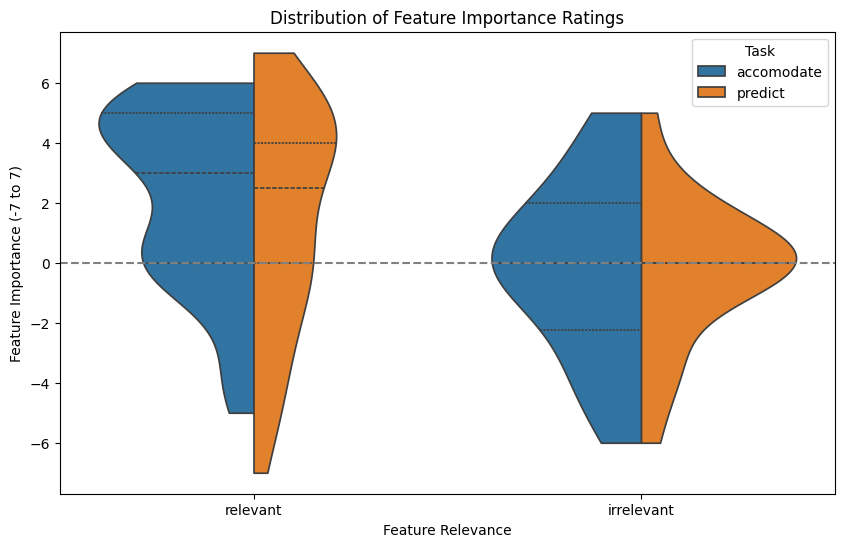

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Violin plot: distribution of ratings by task and relevance
sns.violinplot(
    data=df_long,
    x='feature_relevance',      # relevant / irrelevant
    y='feature_importance',     # -7 to 7
    hue='task',                 # predict / accomodate
    split=True,                 # split the violins by hue
    inner='quartile',            # show median and quartiles
    cut = 0
)

plt.axhline(0, color='gray', linestyle='--')  # line at 0
plt.title('Distribution of Feature Importance Ratings')
plt.ylabel('Feature Importance (-7 to 7)')
plt.xlabel('Feature Relevance')
plt.legend(title='Task')
plt.show()


In [52]:
df_long['task'] = df_long['task'].astype('category')  # predict/accomodate
df_long['feature_dimension'] = df_long['feature_dimension'].astype('category')
df_long['feature_relevance'] = df_long['feature_relevance'].astype('category')


In [206]:
import statsmodels.formula.api as smf

# Random intercepts per participant:
md = smf.mixedlm(
    "feature_importance ~ feature_dimension * task * feature_relevance",
    df_long,
    groups=df_long["participant"],  # random intercept per participant
    # re_formula="~feature_dimension*feature_relevance" # random slopes if model converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())


                                       Mixed Linear Model Regression Results
Model:                             MixedLM                  Dependent Variable:                  feature_importance
No. Observations:                  117                      Method:                              REML              
No. Groups:                        39                       Scale:                               8.1941            
Min. group size:                   3                        Log-Likelihood:                      -283.6266         
Max. group size:                   3                        Converged:                           Yes               
Mean group size:                   3.0                                                                             
-------------------------------------------------------------------------------------------------------------------
                                                                         Coef.  Std.Err.   z    P>|z| [0.025 0.

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


In [53]:
import statsmodels.formula.api as smf

# Random intercepts per participant:
md = smf.mixedlm(
    "feature_importance ~ task * feature_relevance",
    df_long,
    groups=df_long["participant"],  # random intercept per participant
    # re_formula="~feature_dimension*feature_relevance" # random slopes if model converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())

                         Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         feature_importance
No. Observations:         117             Method:                     REML              
No. Groups:               39              Scale:                      10.2919           
Min. group size:          3               Log-Likelihood:             -298.6948         
Max. group size:          3               Converged:                  Yes               
Mean group size:          3.0                                                           
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      0.000    0.718  0.000 1.000 -1.407  1.407
task[T.predict]                                

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [61]:
#Analyse the absolute value of feature importance ratings (ignoring direction)
df_longAbs = df_long.copy()
df_longAbs["abs_feature_importance"] = df_longAbs["feature_importance"].abs()
avg_importance_task = (
    df_longAbs
        .groupby(['task', 'feature_relevance'])['abs_feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance_task)
avg_importance_relevance = (
    df_longAbs
        .groupby(['feature_relevance'])['abs_feature_importance']
        .mean()
        .reset_index()
)

print(avg_importance_relevance)

avg_importance_feature = (
    df_longAbs
        .groupby(['feature_dimension'])['abs_feature_importance']
        .mean()
        .reset_index()
)
print(avg_importance_feature)

         task feature_relevance  abs_feature_importance
0  accomodate        irrelevant                2.150000
1  accomodate          relevant                3.075000
2     predict        irrelevant                1.421053
3     predict          relevant                3.315789
  feature_relevance  abs_feature_importance
0        irrelevant                1.794872
1          relevant                3.192308
  feature_dimension  abs_feature_importance
0             color                2.384615
1             shape                2.948718
2              tail                2.846154


In [73]:
df_irrel = df_longAbs[df_longAbs["feature_relevance"] == "irrelevant"].copy()

accom_vals = df_irrel[df_irrel["task"]=="accomodate"]["abs_feature_importance"]
predict_vals = df_irrel[df_irrel["task"]=="predict"]["abs_feature_importance"]
mean_accom = np.mean(accom_vals)
mean_predict = np.mean(predict_vals)

print(f"Mean (accommodate) = {mean_accom:.3f}")
print(f"Mean (predict) = {mean_predict:.3f}")
t, p = ttest_ind(predict_vals, accom_vals, equal_var=False)  # Welch's t-test
print(f"t = {t:.3f}, p = {p:.4f}")


Mean (accommodate) = 2.150
Mean (predict) = 1.421
t = -1.128, p = 0.2668


In [72]:
#Apply to stats to predict absolute feature importance ratings
import statsmodels.formula.api as smf

md_abs = smf.mixedlm(
    "abs_feature_importance ~ task * feature_relevance",
    df_longAbs,
    groups=df_longAbs["participant"],  # random intercept per participant
    # re_formula="~feature_dimension*feature_relevance"
)

mdf_abs = md_abs.fit(method="lbfgs")
print(mdf_abs.summary())


                         Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       abs_feature_importance
No. Observations:         117           Method:                   REML                  
No. Groups:               39            Scale:                    3.6024                
Min. group size:          3             Log-Likelihood:           -250.8995             
Max. group size:          3             Converged:                Yes                   
Mean group size:          3.0                                                           
----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                      2.150    0.482  4.464 0.000  1.206  3.094
task[T.predict]                               -

/opt/miniconda3/envs/PredictProj/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


**Analysis 3: Predicting Food Consumption Ratings**

In [22]:
#Group by average food amount per item in training
df = df_combined[['task', 'training_image_order', 'food_amount', 'conditionOrder']]
df_long = (
    df
    .explode(['training_image_order', 'food_amount'])
    .rename(columns={'training_image_order': 'item'})
)
avg_food = (
    df_long
    .groupby(['task', 'conditionOrder', 'item'], as_index=False)
    ['food_amount']
    .mean()
)
avg_food_train = avg_food.copy()
#print(avg_food_train.head(20))


In [23]:
#Get food consumption ratings by item

df = df_combined[['task', 'conditionOrder', 'testing_image_order', 'testing_responses', 'relevant_dim_1',
                  'relevant_dim_2', 'irrelevant_dim', 'color_high', 'tail_high', 'shape_high']]
df_long = (
    df
    .explode(['testing_image_order', 'testing_responses'])
    .rename(columns={'testing_image_order': 'item'})
)
avg_food_test = df_long.copy()
print(avg_food_test.head(20))


         task  conditionOrder   item testing_responses relevant_dim_1  \
0  accomodate              19  T_Y_C               4.0          shape   
0  accomodate              19  N_B_S               4.0          shape   
0  accomodate              19  N_B_C               4.0          shape   
0  accomodate              19  N_Y_S               6.0          shape   
0  accomodate              19  T_B_C               3.0          shape   
0  accomodate              19  T_B_S               4.0          shape   
0  accomodate              19  N_Y_C               4.0          shape   
0  accomodate              19  T_Y_S               5.0          shape   
1  accomodate              18  N_Y_S               3.0           tail   
1  accomodate              18  T_B_C               6.0           tail   
1  accomodate              18  T_B_S               7.0           tail   
1  accomodate              18  N_Y_C               1.0           tail   
1  accomodate              18  T_Y_S               

In [24]:
#Now merge the two (actual food amounts in training vs ratings in testing) and compute error
df_merged = avg_food_test.merge(
    avg_food_train,
    on=['task', 'conditionOrder', 'item'],
    how='left'
)

#Error and absolute error
df_merged['error'] = (
    df_merged['testing_responses'] - df_merged['food_amount']
)
df_merged['abs_error'] = df_merged['error'].abs()
df_merged[['tail', 'color', 'shape']] = df_merged['item'].str.split('_', expand=True)

print(df_merged.head(20))

          task  conditionOrder   item testing_responses relevant_dim_1  \
0   accomodate              19  T_Y_C               4.0          shape   
1   accomodate              19  N_B_S               4.0          shape   
2   accomodate              19  N_B_C               4.0          shape   
3   accomodate              19  N_Y_S               6.0          shape   
4   accomodate              19  T_B_C               3.0          shape   
5   accomodate              19  T_B_S               4.0          shape   
6   accomodate              19  N_Y_C               4.0          shape   
7   accomodate              19  T_Y_S               5.0          shape   
8   accomodate              18  N_Y_S               3.0           tail   
9   accomodate              18  T_B_C               6.0           tail   
10  accomodate              18  T_B_S               7.0           tail   
11  accomodate              18  N_Y_C               1.0           tail   
12  accomodate              18  T_Y_S 

In [25]:
#Sanity Check: Mean absolute error by feature (shouldn't be different)

df_merged[['tail', 'color', 'shape']] = df_merged['item'].str.split('_', expand=True)

print("Mean abs_error by tail:")
print(df_merged.groupby('tail')['abs_error'].mean())

print("Mean abs_error by color:")
print(df_merged.groupby('color')['abs_error'].mean())

print("Mean abs_error by shape:")
print(df_merged.groupby('shape')['abs_error'].mean())


Mean abs_error by tail:
tail
N    1.145299
T    1.222222
Name: abs_error, dtype: object
Mean abs_error by color:
color
B    1.273504
Y    1.094017
Name: abs_error, dtype: object
Mean abs_error by shape:
shape
C    1.181624
S    1.185897
Name: abs_error, dtype: object


In [26]:
#t-test: color 1 vs color 2 absolute error 
color1 = df_merged.loc[df_merged['color'] == 'B', 'abs_error']
color2 = df_merged.loc[df_merged['color'] == 'Y', 'abs_error']
t_stat, p_val = stats.ttest_ind(pd.to_numeric(color1), pd.to_numeric(color2), equal_var=False)  # Welch's t-test
print(f"T = {t_stat:.3f}, p = {p_val:.3f}")

T = 1.456, p = 0.146


In [27]:
#t-test: predict vs accomodate absolute error
df_merged['abs_error'] = pd.to_numeric(df_merged['abs_error'])
print(df_merged.groupby('task')['abs_error'].mean())
errors_task1 = df_merged.loc[df_merged['task'] == 'accomodate', 'abs_error']
errors_task2 = df_merged.loc[df_merged['task'] == 'predict', 'abs_error']
from scipy import stats
t_stat, p_val = stats.ttest_ind(errors_task1, errors_task2, equal_var=False)  # Welch's t-test
print(f"T = {t_stat:.3f}, p = {p_val:.3f}")

task
accomodate    1.04375
predict       1.33114
Name: abs_error, dtype: float64
T = -2.330, p = 0.020


In [28]:
print(df_merged.head(20))

          task  conditionOrder   item testing_responses relevant_dim_1  \
0   accomodate              19  T_Y_C               4.0          shape   
1   accomodate              19  N_B_S               4.0          shape   
2   accomodate              19  N_B_C               4.0          shape   
3   accomodate              19  N_Y_S               6.0          shape   
4   accomodate              19  T_B_C               3.0          shape   
5   accomodate              19  T_B_S               4.0          shape   
6   accomodate              19  N_Y_C               4.0          shape   
7   accomodate              19  T_Y_S               5.0          shape   
8   accomodate              18  N_Y_S               3.0           tail   
9   accomodate              18  T_B_C               6.0           tail   
10  accomodate              18  T_B_S               7.0           tail   
11  accomodate              18  N_Y_C               1.0           tail   
12  accomodate              18  T_Y_S 

Part 2: Correlations

In [29]:
# Columns indicating whether the item's feature is the "high" dimension (1/0)
df_merged['tail_match_high']  = (df_merged['tail']  == df_merged['tail_high']).astype(int)
df_merged['color_match_high'] = (df_merged['color'] == df_merged['color_high']).astype(int)
df_merged['shape_match_high'] = (df_merged['shape'] == df_merged['shape_high']).astype(int)
#print(df_merged.head(20))
# Group by participant
participant_corrs = []

for pid, g in df_merged.groupby(['task', 'conditionOrder']):
    for feat in ['tail','color','shape']:
        # Column indicating match to high value
        match_col = f"{feat}_match_high"
        
        # Compute correlation
        corr = g['testing_responses'].corr(g[match_col])
        
        # Determine if this feature is relevant for this participant
        relevant = feat in [g['relevant_dim_1'].iloc[0], g['relevant_dim_2'].iloc[0]]
        
        # Store
        participant_corrs.append({
            'participant': pid,
            'task': g['task'].iloc[0],
            'feature_dimension': feat,
            'feature_relevance': 'relevant' if relevant else 'irrelevant',
            'correlation': corr,
            'abs_correlation': abs(corr) if pd.notna(corr) else None
        })

df_corr = pd.DataFrame(participant_corrs)
print(df_corr.head(20))



        participant        task feature_dimension feature_relevance  \
0   (accomodate, 1)  accomodate              tail        irrelevant   
1   (accomodate, 1)  accomodate             color          relevant   
2   (accomodate, 1)  accomodate             shape          relevant   
3   (accomodate, 2)  accomodate              tail          relevant   
4   (accomodate, 2)  accomodate             color        irrelevant   
5   (accomodate, 2)  accomodate             shape          relevant   
6   (accomodate, 3)  accomodate              tail          relevant   
7   (accomodate, 3)  accomodate             color        irrelevant   
8   (accomodate, 3)  accomodate             shape          relevant   
9   (accomodate, 4)  accomodate              tail        irrelevant   
10  (accomodate, 4)  accomodate             color          relevant   
11  (accomodate, 4)  accomodate             shape          relevant   
12  (accomodate, 5)  accomodate              tail        irrelevant   
13  (a

In [30]:
avg_corr_task_rel = df_corr.groupby(
    ['task'],
    as_index=False
)['correlation'].mean()

print(avg_corr_task_rel)
avg_corr_feature = df_corr.groupby(
    ['feature_dimension'],
    as_index=False
)['correlation'].mean()

print(avg_corr_feature)
avg_corr_relevance = df_corr.groupby(
    ['feature_relevance'],
    as_index=False
)['correlation'].mean()

print(avg_corr_relevance)

         task  correlation
0  accomodate     0.281904
1     predict     0.268852
  feature_dimension  correlation
0             color     0.235120
1             shape     0.303792
2              tail     0.287723
  feature_relevance  correlation
0        irrelevant     0.044345
1          relevant     0.391145


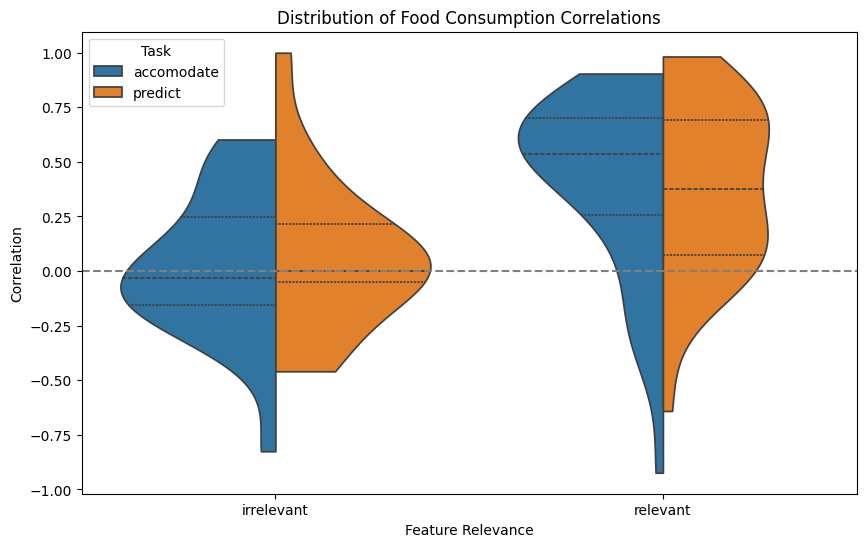

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Violin plot: distribution of ratings by task and relevance
sns.violinplot(
    data=df_corr,
    x='feature_relevance',      # relevant / irrelevant
    y='correlation',     # -7 to 7
    hue='task',                 # predict / accomodate
    split=True,                 # split the violins by hue
    inner='quartile',            # show median and quartiles
    cut = 0
)

plt.axhline(0, color='gray', linestyle='--')  # line at 0
plt.title('Distribution of Food Consumption Correlations')
plt.ylabel('Correlation')
plt.xlabel('Feature Relevance')
plt.legend(title='Task')
plt.show()


In [353]:
avg_corr_task_rel = df_corr.groupby(
    ['task', 'feature_relevance'],
    as_index=False
)['correlation'].mean()

print(avg_corr_task_rel)


         task feature_relevance  correlation
0  accomodate        irrelevant     0.031596
1  accomodate          relevant     0.407057
2     predict        irrelevant     0.057764
3     predict          relevant     0.374396


In [352]:
import statsmodels.formula.api as smf

md = smf.mixedlm(
    "correlation ~ task * feature_relevance * feature_dimension",
    df_corr,
    groups=df_corr["participant"],  # random intercept per participant
    re_formula="~feature_dimension*feature_relevance"  # optional random slopes if it converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())


                                                                Mixed Linear Model Regression Results
Model:                                                MixedLM                                     Dependent Variable:                                     correlation
No. Observations:                                     117                                         Method:                                                 REML       
No. Groups:                                           39                                          Scale:                                                  0.0098     
Min. group size:                                      3                                           Log-Likelihood:                                         -57.1277   
Max. group size:                                      3                                           Converged:                                              Yes        
Mean group size:                                      3.0           

In [358]:
avg_corr_task_rel = df_corr.groupby(
    ['task'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_task_rel)
avg_corr_feature = df_corr.groupby(
    ['feature_dimension'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_feature)
avg_corr_relevance = df_corr.groupby(
    ['feature_relevance'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_relevance)

         task  abs_correlation
0  accomodate         0.437454
1     predict         0.368037
  feature_dimension  abs_correlation
0             color         0.334600
1             shape         0.443085
2              tail         0.433222
  feature_relevance  abs_correlation
0        irrelevant         0.244987
1          relevant         0.482960


In [360]:
avg_corr_task_rel = df_corr.groupby(
    ['task', 'feature_relevance'],
    as_index=False
)['abs_correlation'].mean()

print(avg_corr_task_rel)


         task feature_relevance  abs_correlation
0  accomodate        irrelevant         0.256107
1  accomodate          relevant         0.528127
2     predict        irrelevant         0.233281
3     predict          relevant         0.435414


In [361]:
import statsmodels.formula.api as smf

md = smf.mixedlm(
    "abs_correlation ~ task * feature_relevance * feature_dimension",
    df_corr,
    groups=df_corr["participant"],  # random intercept per participant
    re_formula="~feature_dimension*feature_relevance"  # optional random slopes if it converges
)
mdf = md.fit(method='lbfgs')
print(mdf.summary())


                                                               Mixed Linear Model Regression Results
Model:                                              MixedLM                                   Dependent Variable:                                   abs_correlation
No. Observations:                                   117                                       Method:                                               REML           
No. Groups:                                         39                                        Scale:                                                0.0156         
Min. group size:                                    3                                         Log-Likelihood:                                       -13.1383       
Max. group size:                                    3                                         Converged:                                            Yes            
Mean group size:                                    3.0                        

In [ ]:
import ast
import matplotlib.pyplot as plt
#Calculate reported food amounts during testing
def AverageFoodCalclator(participants_to_use):
    df_subset = df_combined[df_combined['participant'].isin(participants_to_use)]
    all_trials = []
    for i in df_subset['participant']:
        ratings     = df_subset[df_subset['participant'] == i]['testing_responses'].iloc[0]
        categories = df_subset[df_subset['participant'] == i]['testing_categories'].iloc[0]
        task = df_subset[df_subset['participant'] == i]['task'].iloc[0]
        row = df_subset[df_subset['participant'] == i].iloc[0]
        tail_yes  = 1 if row['tail_discrete_slider.response']  == 'Yes' else 0
        shape_yes = 1 if row['shape_discrete_slider.response'] == 'Yes' else 0
        color_yes = 1 if row['color_discrete_slider.response'] == 'Yes' else 0
        num_features_relevant = tail_yes + shape_yes + color_yes
        df_participant = pd.DataFrame(list(zip(
            [i]*len(ratings),  # Repeat participant ID and task to match the number of ratings
            ratings,
            [task]*len(ratings), # Repeat participant ID and task to match the number of ratings
            categories,
            [num_features_relevant]*len(ratings)
        )), columns=['participant', 'ratings', 'task', 'category', 'num_features_relevant'])
        all_trials.append(df_participant)
    df_average = pd.concat(all_trials, ignore_index=True)
    avg_ratings_cond = df_average.groupby(['task', 'category'])['ratings'].mean()
    return df_average, avg_ratings_cond

participants_to_use = df_combined['participant'].tolist()
df_average, avg_rating_cond = AverageFoodCalclator(participants_to_use)
print(avg_rating_cond)
print(df_average)
# Group by task, category, and num_features_relevant
model_parameter_score = df_average.groupby(
    ['num_features_relevant']
)['ratings'].mean().reset_index()

print(model_parameter_score)
# Group by task, category, and num_features_relevant
avg_ratings_cond_by_relevance = df_average.groupby(
    ['task', 'category', 'num_features_relevant']
)['ratings'].mean().reset_index()


print(avg_ratings_cond_by_relevance)
category_order = ['low', 'medium', 'high']
avg_ratings_cond_by_relevance['category'] = pd.Categorical(
    avg_ratings_cond_by_relevance['category'],
    categories=category_order,
    ordered=True
)
import seaborn as sns
sns.catplot(
    data=avg_ratings_cond_by_relevance,
    x='category', y='ratings',
    hue='num_features_relevant', col='task',
    kind='bar', palette='Set2'
)
plt.show()

<Axes: xlabel='category', ylabel='ratings'>

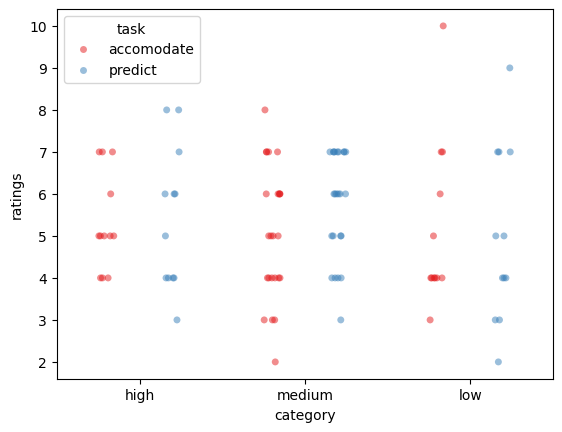

In [14]:
sns.stripplot(data=df_average, x='category', y='ratings', hue='task', 
              palette='Set1', dodge=True, jitter=True, color='black', alpha=0.5)

In [17]:
print(df_average.head(20))

    participant  ratings        task category  num_features_relevant
0             1      6.0  accomodate     high                      1
1             1      5.0  accomodate   medium                      1
2             1      3.0  accomodate      low                      1
3             1      5.0  accomodate   medium                      1
4             1      5.0  accomodate   medium                      1
5             1      7.0  accomodate     high                      1
6             1      4.0  accomodate      low                      1
7             1      4.0  accomodate   medium                      1
8             2      5.0  accomodate   medium                      2
9             2      3.0  accomodate   medium                      2
10            2      5.0  accomodate     high                      2
11            2      7.0  accomodate      low                      2
12            2      7.0  accomodate     high                      2
13            2      5.0  accomoda

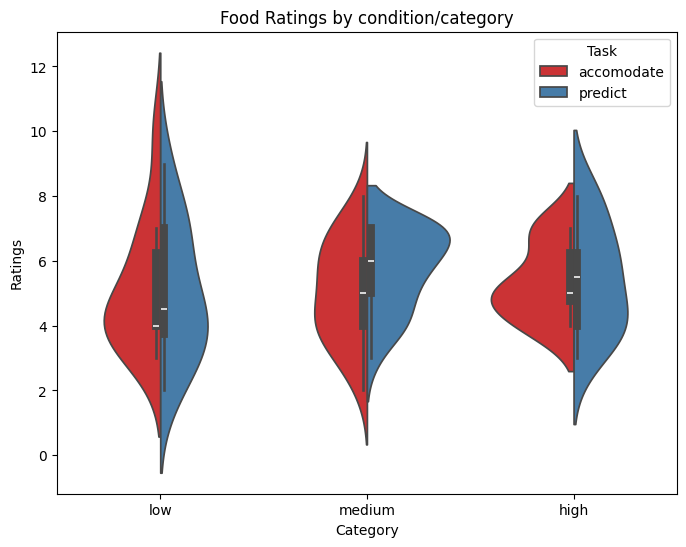

In [15]:
order = ['low', 'medium', 'high']
# Violin plot: ratings by category, separated by task
plt.figure(figsize=(8,6))
sns.violinplot(
    data=df_average,
    x='category',       # x-axis: categories
    y='ratings',        # y-axis: ratings
    hue='task',         # split by task
    split=True,         # split the violins by task
    palette='Set1',
    inner='box',    # show box plot of data inside
    order = order
)

plt.ylabel('Ratings')
plt.xlabel('Category')
plt.title('Food Ratings by condition/category')
plt.legend(title='Task')
#plt.savefig(f'{study}Plots/ViolinRatings.png', bbox_inches='tight')
plt.show()

In [38]:
def decode_rel(rel_values):
    """
    rel_values: Series of lists of rel codes
    """

    flat_vals = []
    for v in rel_values:
        if isinstance(v, list):
            flat_vals.extend(v)

    flat_vals = pd.Series(flat_vals).dropna().unique()

    if len(flat_vals) == 0:
        return pd.Series({'feature_relevance': np.nan})

    # irrelevant: only I-codes
    if all(v.startswith('I') for v in flat_vals):
        return pd.Series({'feature_relevance': 'irrelevant'})

    # relevant: contains R or L
    if any(v.startswith(('R', 'L')) for v in flat_vals):
        return pd.Series({'feature_relevance': 'relevant'})

    raise ValueError(f"Unexpected rel codes: {flat_vals}")


feature_relevance_rows = []

for (cond, task), subdf in df_combined.groupby(['conditionOrder', 'task']):
    for feat in ['tail', 'color', 'shape']:
        relevance = decode_rel(subdf[f'training_{feat}'])

        feature_relevance_rows.append({
            'conditionOrder': cond,
            'task': task,
            'feature_dimension': feat,
            'feature_relevance': relevance
        })

df_feature_relevance = pd.DataFrame(feature_relevance_rows)
print(df_feature_relevance)

    conditionOrder        task feature_dimension  \
0                1  accomodate              tail   
1                1  accomodate             color   
2                1  accomodate             shape   
3                1     predict              tail   
4                1     predict             color   
5                1     predict             shape   
6                2  accomodate              tail   
7                2  accomodate             color   
8                2  accomodate             shape   
9                2     predict              tail   
10               2     predict             color   
11               2     predict             shape   
12               3  accomodate              tail   
13               3  accomodate             color   
14               3  accomodate             shape   
15               3     predict              tail   
16               3     predict             color   
17               3     predict             shape   
18          

In [41]:
features = ['shape', 'color', 'tail']
long_rows = []

for _, row in df_combined.iterrows():
    for feat in features:
        long_rows.append({
            'participant': row['participant'],
            'conditionOrder': row['conditionOrder'],
            'task': row['task'],
            'feature_dimension': feat,

            'discrete': row[f'{feat}_discrete_slider.response'],
            'direction': row[f'{feat}_direction_slider.response'],
            'continuous': row[f'{feat}_continuous_slider.response'],
        })

df_long = pd.DataFrame(long_rows)
print(df_long.head(10))

   participant  conditionOrder        task feature_dimension discrete  \
0            1               4  accomodate             shape      Yes   
1            1               4  accomodate             color       No   
2            1               4  accomodate              tail       No   
3            2               1  accomodate             shape       No   
4            2               1  accomodate             color      Yes   
5            2               1  accomodate              tail      Yes   
6            3               3  accomodate             shape      Yes   
7            3               3  accomodate             color      Yes   
8            3               3  accomodate              tail      Yes   
9            4               2  accomodate             shape      Yes   

       direction  continuous  
0         Square         5.0  
1            NaN         NaN  
2            NaN         NaN  
3            NaN         NaN  
4           Blue         4.0  
5  Having 

In [45]:
df_long = df_long.merge(
    df_feature_relevance,
    on=['conditionOrder', 'task', 'feature_dimension'],
    how='left'
)
print(df_long.head(21))

    participant  conditionOrder        task feature_dimension discrete  \
0             1               4  accomodate             shape      Yes   
1             1               4  accomodate             color       No   
2             1               4  accomodate              tail       No   
3             2               1  accomodate             shape       No   
4             2               1  accomodate             color      Yes   
5             2               1  accomodate              tail      Yes   
6             3               3  accomodate             shape      Yes   
7             3               3  accomodate             color      Yes   
8             3               3  accomodate              tail      Yes   
9             4               2  accomodate             shape      Yes   
10            4               2  accomodate             color      Yes   
11            4               2  accomodate              tail      Yes   
12            5               2     pr